# **Twitter Network Analysis**

This notebook contains a social network analysis mainly executed with the library of NetworkX. In detail, this dataset consists of 'circles' (or 'lists') from Twitter. Twitter data was crawled from public sources. The dataset includes node features (profiles), circles, and ego networks. The dataset can be found at this link: [Stanford Twitter Dataset](https://snap.stanford.edu/data/ego-Twitter.html).

## Import packages

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

## Analysis
The edges are loaded from the `data` folder and saved in a dataframe. Each edge is a new row and for each edge there is a `start_node` and an `end_node` column

In [ ]:
twitter = pd.read_csv(
    "https://snap.stanford.edu/data/twitter_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
twitter = twitter.iloc[:80000]

In [ ]:
twitter.head()

start_node   end_node
0   214328887   34428380
1    17116707   28465635
2   380580781   18996905
3   221036078  153460275
4   107830991   17868918

The graph is created from the `twitter` dataframe of the edges:

In [ ]:
G = nx.from_pandas_edgelist(twitter, "start_node", "end_node")

## Visualizing the graph

Let's start our exploration by visualizing the graph. Visualization plays a
central role in exploratory data analysis to help get a qualitative feel for
the data.

Since we don't have any real sense of structure in the data, let's start by
viewing the graph with `random_layout`, which is among the fastest of the layout
functions.

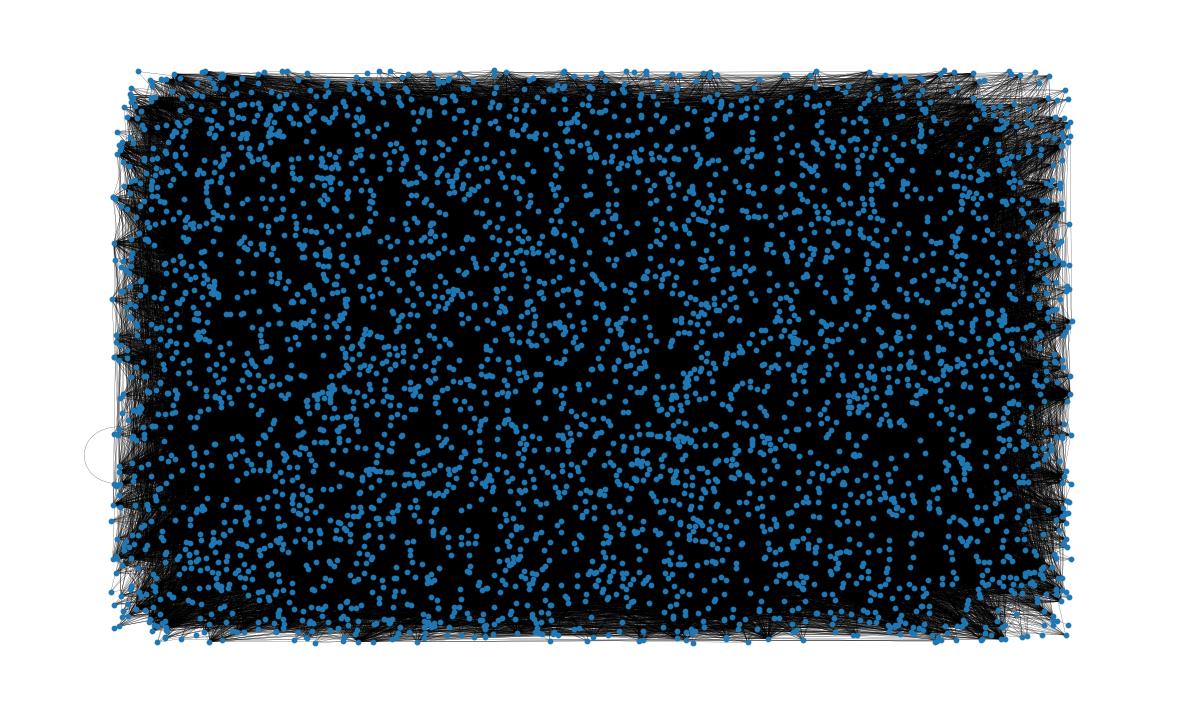

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

Do we need more or less information (nodes or edges) from the graph to do the analysis? Let's check `spring_layout` and continue analysis...

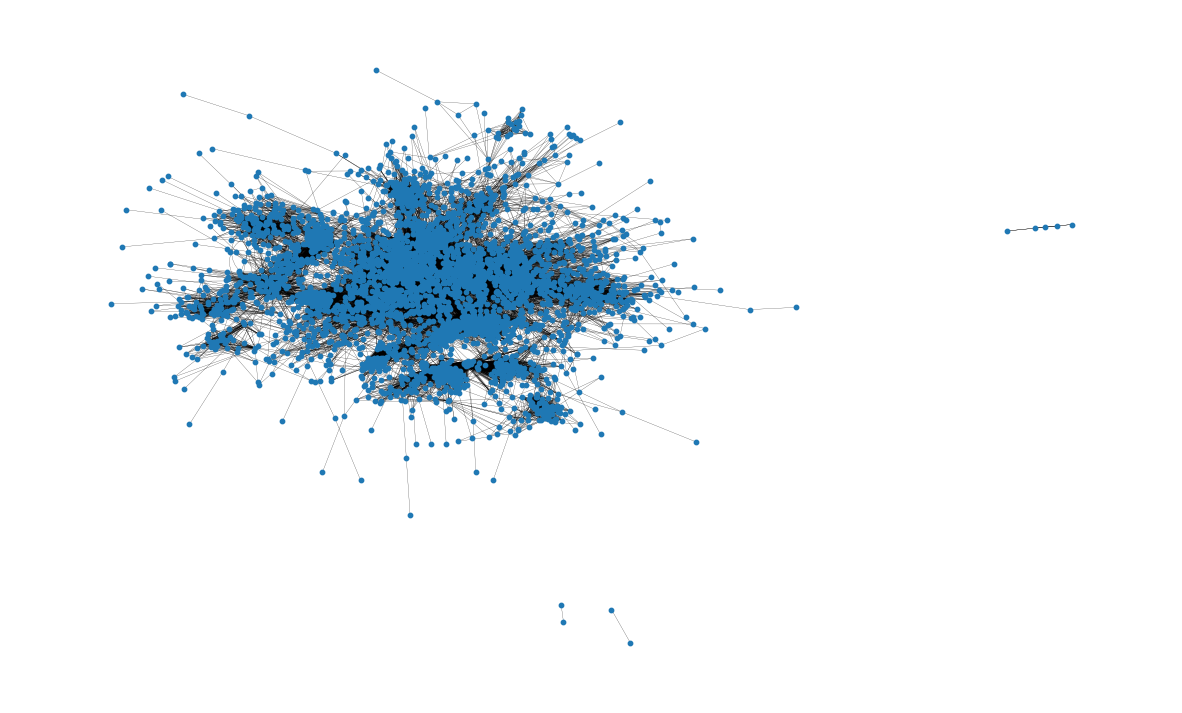

In [ ]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

What other information can we extract from this network? ... (check graphs metrics)

# **Análisis básico**

A continuación se realizará un análisis inicial del grafo explorando sus características

## *Cantidad total de nodos*


In [ ]:
G.number_of_nodes()

4316

## *Cantidad total de conexiones*

In [ ]:
G.number_of_edges()

58270

## *Cantidad de subgrafos*

Primero vamos a averiguar si todos los nodos estan conectados entre sí

In [ ]:
nx.is_connected(G)

False

In [ ]:
nx.number_connected_components(G)

7

Al encontrar que los nodos no están conectados, se calcula los subgrafos con el fin de calcular el diametro entre ellos

In [ ]:
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

[4143, 95, 48, 21, 5, 2, 2]

Se observa que hay 6 subnodos conectados, a cada uno de ellos se le calcula el diametro de cada uno de ellos. Posteriormente, se genera una lista para generar cada `grafico de ego`

In [ ]:
sub_grafos = list(sorted(nx.connected_components(G), key=len, reverse=True))
len(sub_grafos)

7

## *Promedio de conexiones de los nodos*

En promedio, un nodo esta conectado a 27 nodos

In [ ]:
np.mean([d for _, d in G.degree()])

27.00185356811863

## *Longitud de ruta más corta para todos los pares de nodos en la red*

In [ ]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

In [ ]:
twitter['start_node'].unique()

array([214328887,  17116707, 380580781, ...,  39680464, 130922325,
          820281])

Se calcula la longitud de la ruta más corta entre dos nodos aleatorios. Entre el nodo 17116707 y el nodo 130922325 la longitud más corta es de 8

In [ ]:
shortest_path_lengths[17116707][130922325]

8

## *Promedio de la longitud del camino más corto*

A continuación se calcula el promedio de la longitud del camino más corto para todos los pares de nodos: para llegar de un nodo a otro, se atravesarán aproximadamente 4,8 aristas en promedio

In [ ]:
average_path_lengths_ = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values() if shortest_path_lengths.keys()
]
np.mean(average_path_lengths_)

4.837700405033223

In [ ]:
print(G)

Graph with 4316 nodes and 58270 edges


# **Distancia minima por subgrupo**

In [ ]:
shortest_path_lengths_ = []
for idx, component in enumerate(sub_grafos):
  component_graph = G.subgraph(component)
  shortest_path_lengths_.append(dict(nx.all_pairs_shortest_path_length(component_graph)))
  print(f"Se ejecutó correctamente el camino más corto para el subgrafo #{idx+1}")

Se ejecutó correctamente el camino más corto para el subgrafo #1
Se ejecutó correctamente el camino más corto para el subgrafo #2
Se ejecutó correctamente el camino más corto para el subgrafo #3
Se ejecutó correctamente el camino más corto para el subgrafo #4
Se ejecutó correctamente el camino más corto para el subgrafo #5
Se ejecutó correctamente el camino más corto para el subgrafo #6
Se ejecutó correctamente el camino más corto para el subgrafo #7


In [ ]:
average_path_lengths_subgraph = []
for idx, shortest_path_subgraph in enumerate(shortest_path_lengths_):
  # Distancia promedio de cada nodo
  average_path_lengths = [
      np.mean(list(spl.values())) for spl in shortest_path_subgraph.values()
  ]
  # Promedio de todos los nodos del subgrafo
  print(f"Distancia promedio del subgrafo #{idx+1} es: {np.mean(average_path_lengths)}")
  average_path_lengths_subgraph.append(np.mean(average_path_lengths)) #guarda las soluciones en un vector en caso de ser necesarias luego

Distancia promedio del subgrafo #1 es: 4.959718427314503
Distancia promedio del subgrafo #2 es: 2.2391135734072023
Distancia promedio del subgrafo #3 es: 1.7361111111111114
Distancia promedio del subgrafo #4 es: 1.3786848072562359
Distancia promedio del subgrafo #5 es: 0.8799999999999999
Distancia promedio del subgrafo #6 es: 0.5
Distancia promedio del subgrafo #7 es: 0.5


Se observa que entre la distancia promedio total y por cada nodo se tiene cierta variación, sin embargo, se aprecia que el promedio total es muy cercano a la distancia total del subgrafo #1

## *Diametro*

A continuación se va calcular la distancia máxima de ir de un nodo a otro

Se generan los subgrafos para cada diámetro

In [ ]:
diameters = []
for component in sub_grafos:
    component_graph = G.subgraph(component)
    diameters.append(max(nx.eccentricity(component_graph, sp=shortest_path_lengths).values()))
diameters

[16, 5, 4, 2, 2, 1, 1]

Se observa que para el grafo más grande para recorrerlo completamente se requieren 16 nodos, para el siguiente 5 y así sucesivamente con el resto de subgrafos.

## Grafico de distribuciones

Se procede a observar las distribuciones de distancias de los nodos. Para esta solo se tomará hasta el subgrafo 3 ya que de ahí en adelante la distribución mayor es 2.

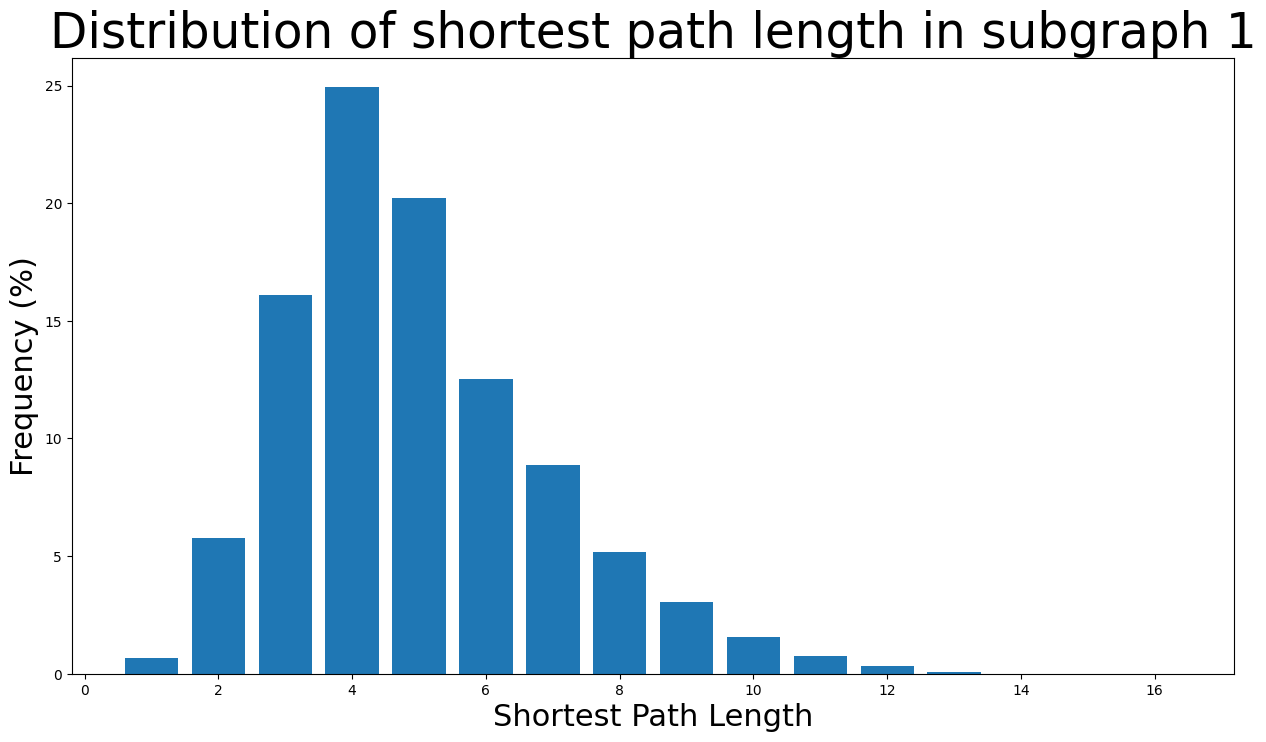

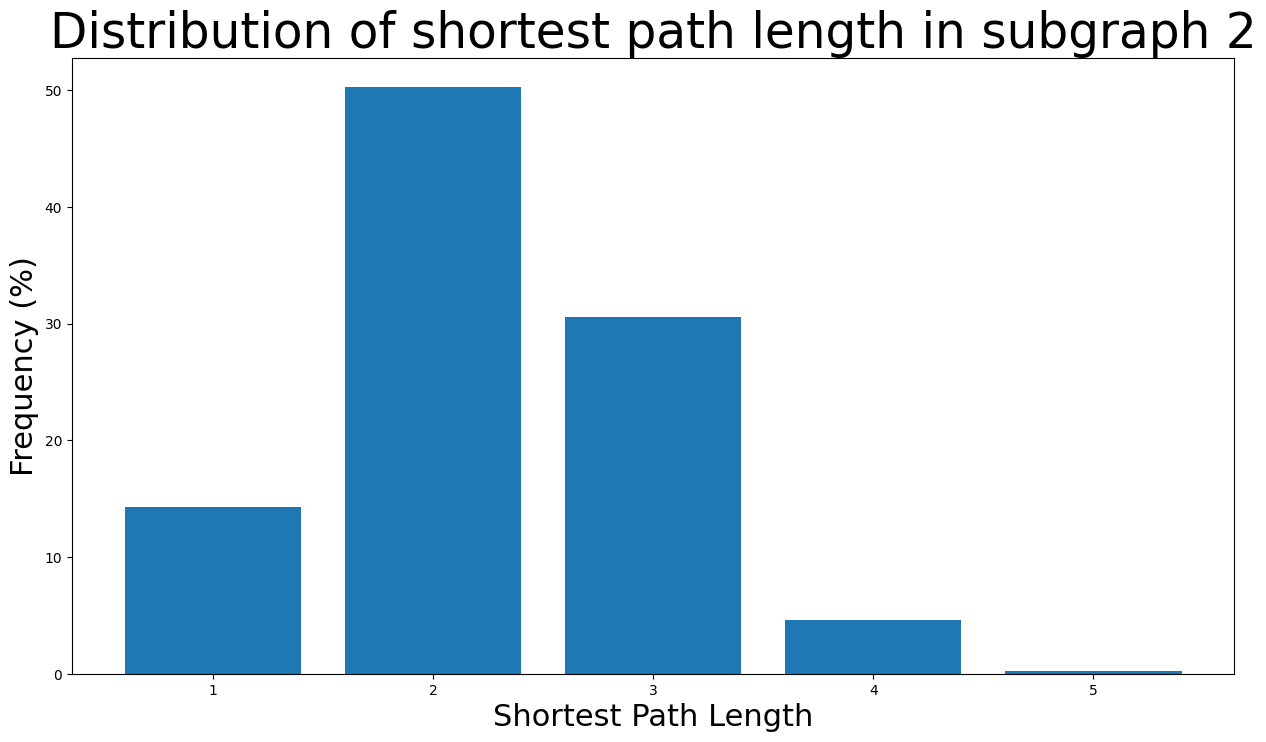

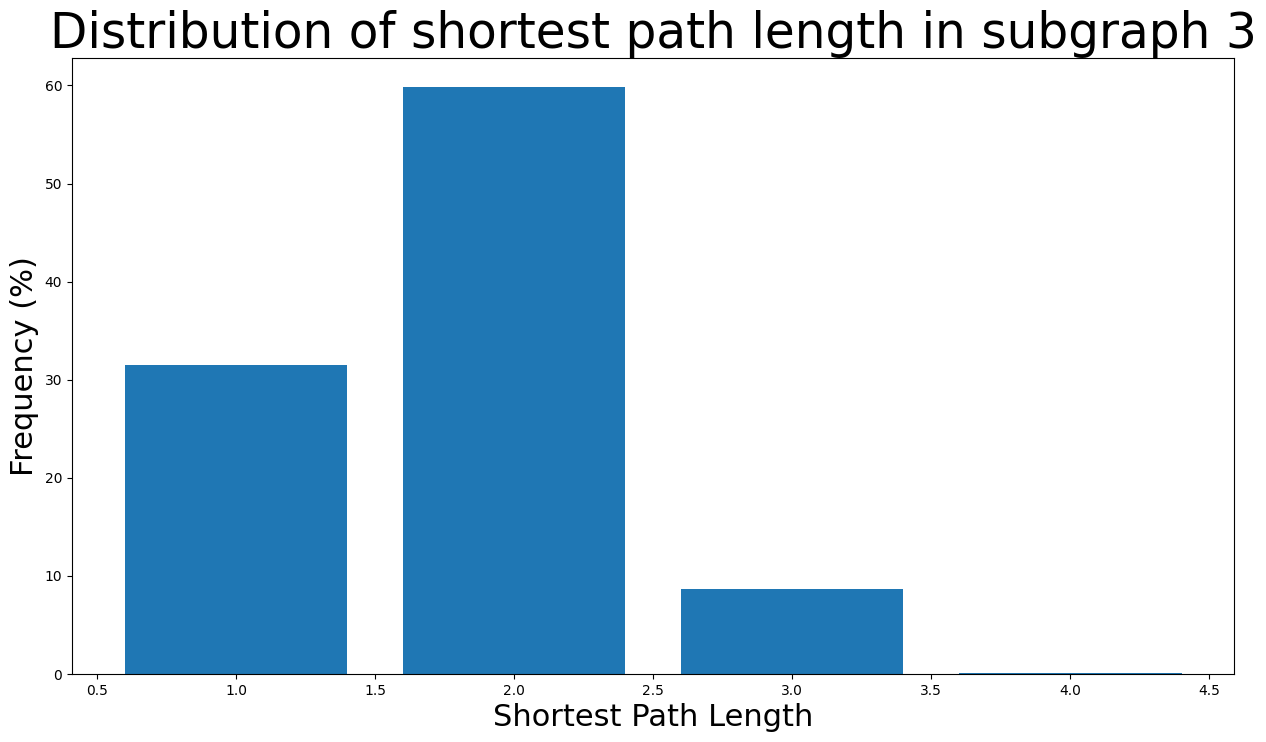

In [ ]:
for idx, diameter in enumerate(diameters[:3]):
# Se genera un vector con todos los posibles valores hasta el máximo (el diametro)
  path_lengths = np.zeros(diameter + 1, dtype=int)

  # Extraemos la frecuencia de los caminos mas cortos entre dos nodos
  a=shortest_path_lengths_[idx]
  for pls in a.values():
      pl, cnts = np.unique(list(pls.values()), return_counts=True)
      path_lengths[pl] += cnts

  # Se calcula el porcentaje de frecuencia de distribución
  freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

  # Se grafica el porcentaje de frecuencia de distribución
  fig, ax = plt.subplots(figsize=(15, 8))
  ax.bar(np.arange(1, diameter + 1), height=freq_percent)
  ax.set_title(
      f"Distribution of shortest path length in subgraph {idx+1}", fontdict={"size": 35}, loc="center"
  )
  ax.set_xlabel("Shortest Path Length", fontdict={"size": 22})
  ax.set_ylabel("Frequency (%)", fontdict={"size": 22})

Se muestra para el gráfico 1 que mayormente para ir de un nodo a otro se requiere de sólo 4 nodos. Muestra una distribución bastante simétrica y con 4 nodos teniendo un porcentaje de 25% de aparición.

Por su parte en el subgrafo 2 mayormente (un 50%) solo requieren pasar por dos nodos para poder llegar al destino deseado.

Por último el subgrafo 3 también tiene un 60% de los nodos que sólo deben pasar por dos puntos para llegar al destino.



## Densidad del grafo

Total

In [ ]:
nx.density(G)

0.0062576717423218145

Se muestra que en conjunto todo es disperso al ser menor que 1 este indicador

Por cada subgrafo

In [ ]:
subgraph = []
for idx, component in enumerate(sub_grafos):
    component_graph = G.subgraph(component)
    subgraph.append(component_graph) #se crea para no tener que volver a llamar la función G.subgraph
    print(f"El subgrafo #{idx+1} tiene una densidad de: {nx.density(component_graph)}")


El subgrafo #1 tiene una densidad de: 0.006660720385755359
El subgrafo #2 tiene una densidad de: 0.1428891377379619
El subgrafo #3 tiene una densidad de: 0.3147163120567376
El subgrafo #4 tiene una densidad de: 0.5523809523809524
El subgrafo #5 tiene una densidad de: 0.9
El subgrafo #6 tiene una densidad de: 1.0
El subgrafo #7 tiene una densidad de: 1.0


Se muestra que a menor cantidad de nodos, menos disperso.

Adicionalmente, se muestra que el subgrafo 1 es muy similar al valor de densidad total.

# **Subgrafo a analizar**

Debido a que hay varios subgrafos, decidimos enfocarnos en el subgrafo mas grande para realizar los análisis porteriores

In [ ]:
subgrafo = subgraph[0]
subgrafo

# **Centralidad**

## Grado de centralidad

El grado de centralidad son las cantidad de conexiones o links para cada nodo. Para este caso, a mayor grado de centralidad mayor importancia tiene el nodo (posiblemente corresponde a un influencer) por su cantidad de seguidores

In [ ]:
degree_centrality = nx.centrality.degree_centrality(
    subgrafo
)  # se guarda el resultado en una variable
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(48485771, 0.07315306615161757),
 (5442012, 0.07098020280057943),
 (3359851, 0.06856591018831482),
 (40981798, 0.06518590053114437),
 (43003845, 0.06180589087397392),
 (34428380, 0.058667310478029935),
 (22462180, 0.05842588121680348),
 (15913, 0.05818445195557701)]

Lo anterior indica por ejemplo que el usuario 48485771 tiene conexión con alrededor del 7% de toda la red. Además estos 8 nodos son los nodos foco o nodos destacados de la red, esto quiere decir que son los mas influyentes de twitter.

Luego, se exploran los vecinos de los nodos con mayor grado de centralidad:

En este caso, el usuario 48485771 tiene 303 nodos vecinos, en otras palabras, este usuario esta conectado a 303 personas.

In [ ]:
(sorted(subgrafo.degree, key=lambda item: item[1], reverse=True))[:8]

[(48485771, 303),
 (5442012, 294),
 (3359851, 284),
 (40981798, 270),
 (43003845, 256),
 (34428380, 243),
 (22462180, 242),
 (15913, 241)]

En el siguiente histograma es visible que todos de usuarios de Twitter tienen grado de centralidad inferiores a 0,05. Incluso la mayoría tiene menos de 0,0125. Lo anterior es debido a que solo se utilizó un subgrafo y además no estan interconectados en la red

Text(0, 0.5, 'Counts')

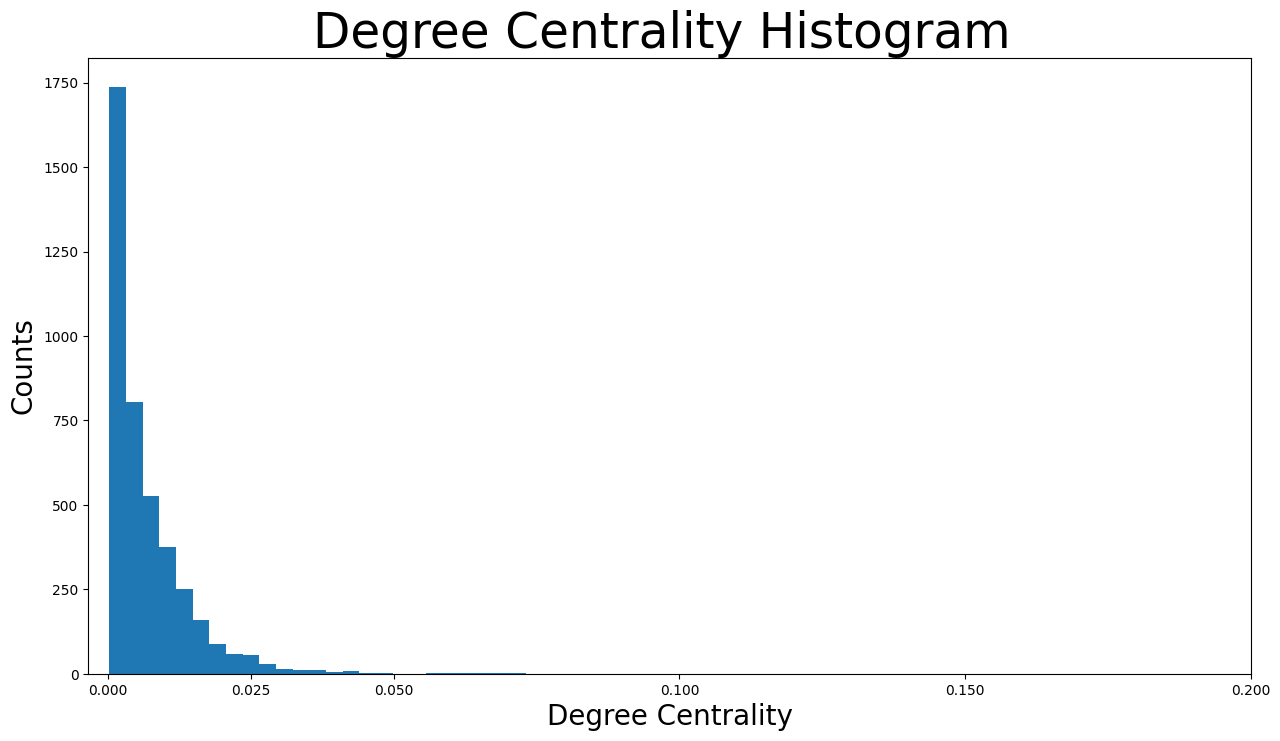

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-0.5816506557166576,
 0.6824601404368877,
 -0.6988945606350899,
 0.6674337390065194)

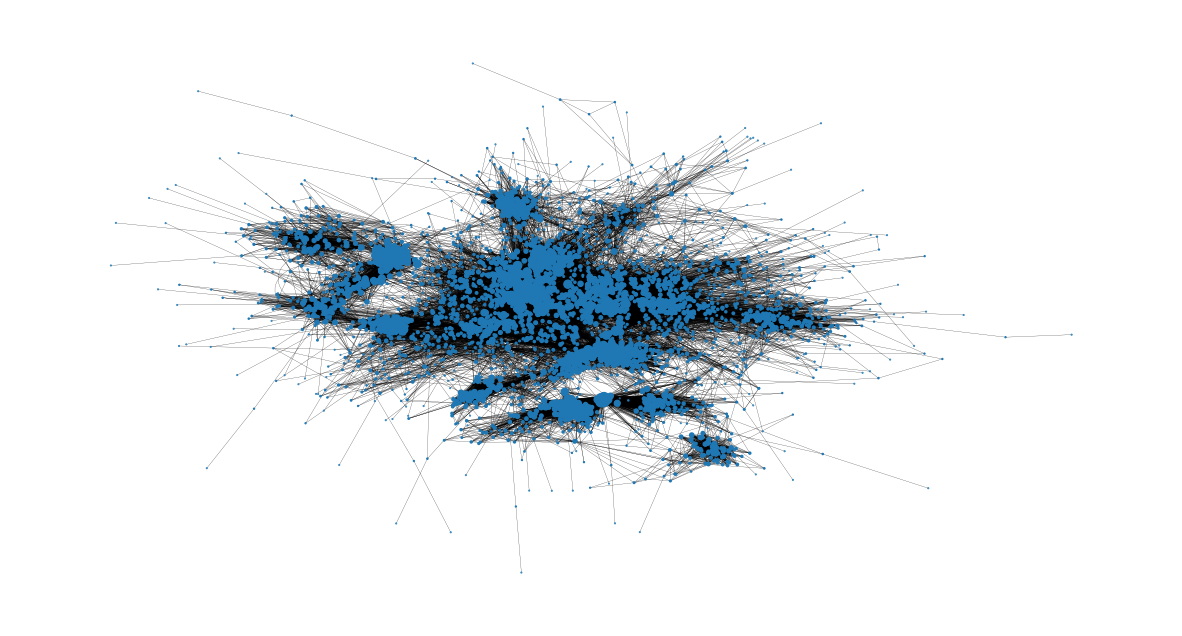

In [ ]:
node_size = [
    v * 1000 for v in degree_centrality.values()
]
plt.figure(figsize=(15, 8))
nx.draw_networkx(subgrafo, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

## Centralidad de intermediación

Esta métrica evalúa en que medida un nodo actúa como puente entre otros nodos, es decir, mide la cantidad de veces que un nodo se encuentra en el camino más corto entre otros nodos.
En el análisis de Twitter se asocia con la capacidad del usuario para influir a los demás.

In [ ]:
betweenness_centrality = nx.centrality.betweenness_centrality(
    subgrafo
)  # se guarda el resultado en una variable
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(6207392, 0.187282515621472),
 (3359851, 0.16760949954924076),
 (783214, 0.10584733363334543),
 (41716273, 0.10063551059961529),
 (17093617, 0.09847618351053983),
 (27634404, 0.09319389420133531),
 (15666380, 0.08632136611199669),
 (48485771, 0.062281887176774915)]

Lo anterior nos dice que los nodos 6207392 y 3359851 son los de mayor grado de intermediación . Adicionalmente, se observa que los nodos 3359851 y 48485771 son **nodos foco** porque hacen parte también de los nodos con centralidades de mayor grado. Los demás no hacen parte de los nodos con mayor grado de centralidad, por ende, aunque esos nodos no son los usuarios más  populares de la red, tienen influencia entre los amigos destacados cuando se trata de difundir información.

Text(0, 0.5, 'Counts')

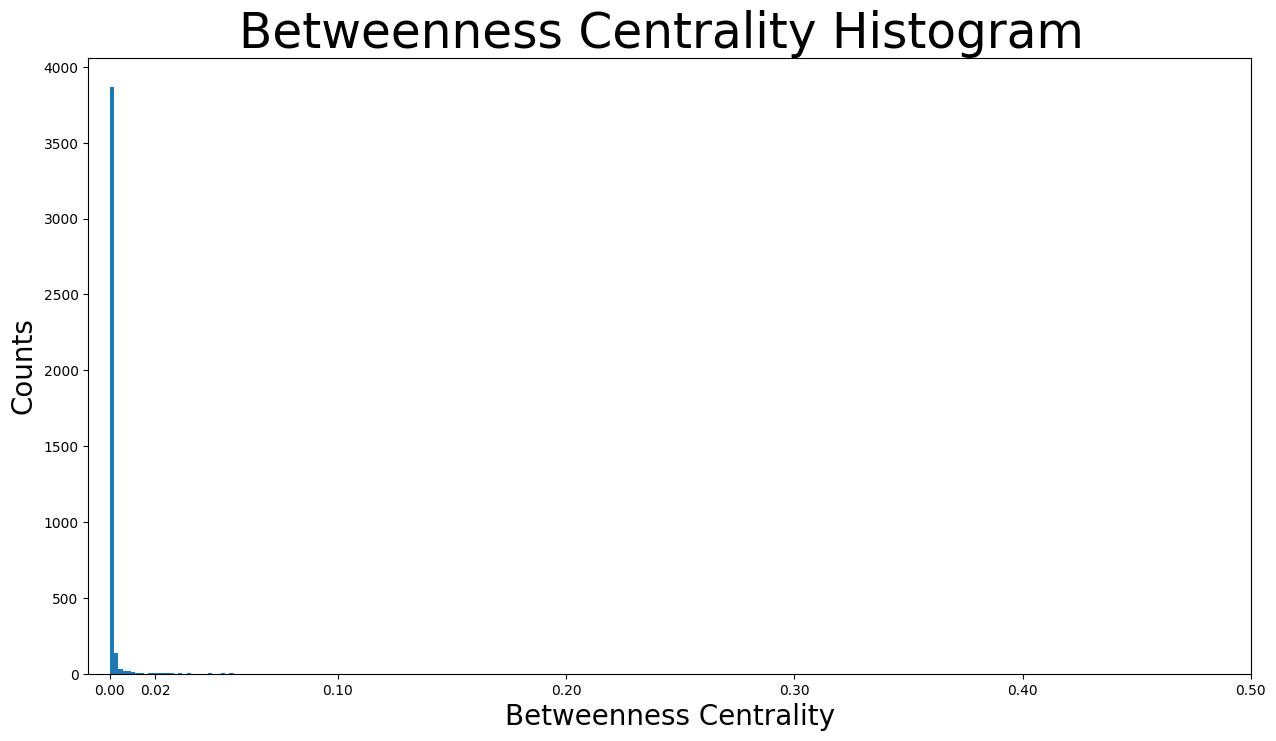

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=100)
plt.xticks(ticks=[0, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.title("Betweenness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Betweenness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

Como se puede ver en el histograma de centralidad de intermediación, la gran mayoría se encuentran por debajo de 0,05 porque la gran mayoría de nodos no actúan como puentes en los caminos más cortos. Incluso, los nodos que actúan como puentes tienen centralidades de intermediación muy bajas

(-0.5816506557166576,
 0.6824601404368877,
 -0.6988945606350899,
 0.6674337390065194)

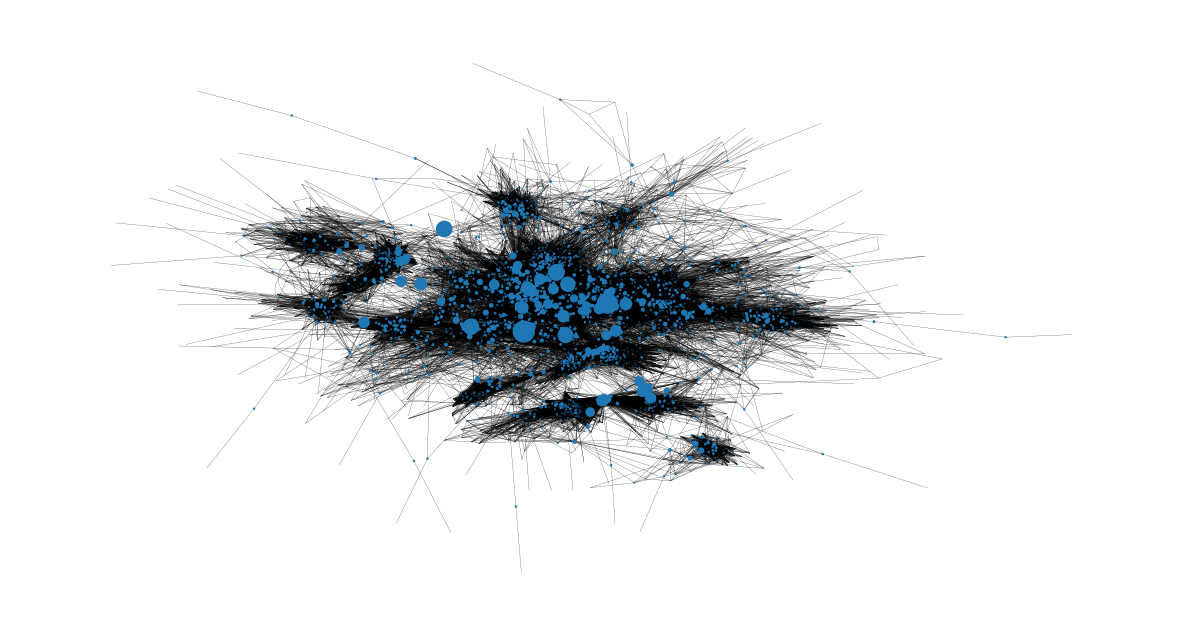

In [ ]:
node_size = [
    v * 1200 for v in betweenness_centrality.values()
]
plt.figure(figsize=(15, 8))
nx.draw_networkx(subgrafo, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

En la gráfica anterior se puede observar los nodos con mayor centralidad de intermediación. Algunos son muy claros y distintivos, mientras otros no.

## Centralidad de cercanía

Cuantifíca que tan cerca esta un nodo de otro. En el contexto de Twitter, nos sirve para encontrar que personas influyen mas en los demás usuarios. Adicionalmente, un nodo con alta centralidad hace que la información se difunda con mayor velocidad

In [ ]:
closeness_centrality = nx.centrality.closeness_centrality(
    subgrafo
)
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(3359851, 0.3307514173919987),
 (15234657, 0.31140515750695436),
 (48485771, 0.3070194944778),
 (7860742, 0.3059988179669031),
 (15666380, 0.30288848263254115),
 (20880546, 0.3027556465170675),
 (3829151, 0.29886716213291004),
 (115485051, 0.2970027247956403)]

Los nodos con mayor centralidad de cercanía son 3359851, 15234657. Entre los 8 nodos con mayor centralidad de cercanía no existe una gran brecha entre ellos.
Adicional a eso, los nodos 33559851 y 484885771 quienes son nodos focos, también hacen parte de los nodos con mayores centralidades de cercanía.

Se calcula el promedio de la distancia de un nodo a cualquiera de los otros

In [ ]:
1 / closeness_centrality[3359851]

3.023418638338967

Text(0, 0.5, 'Counts')

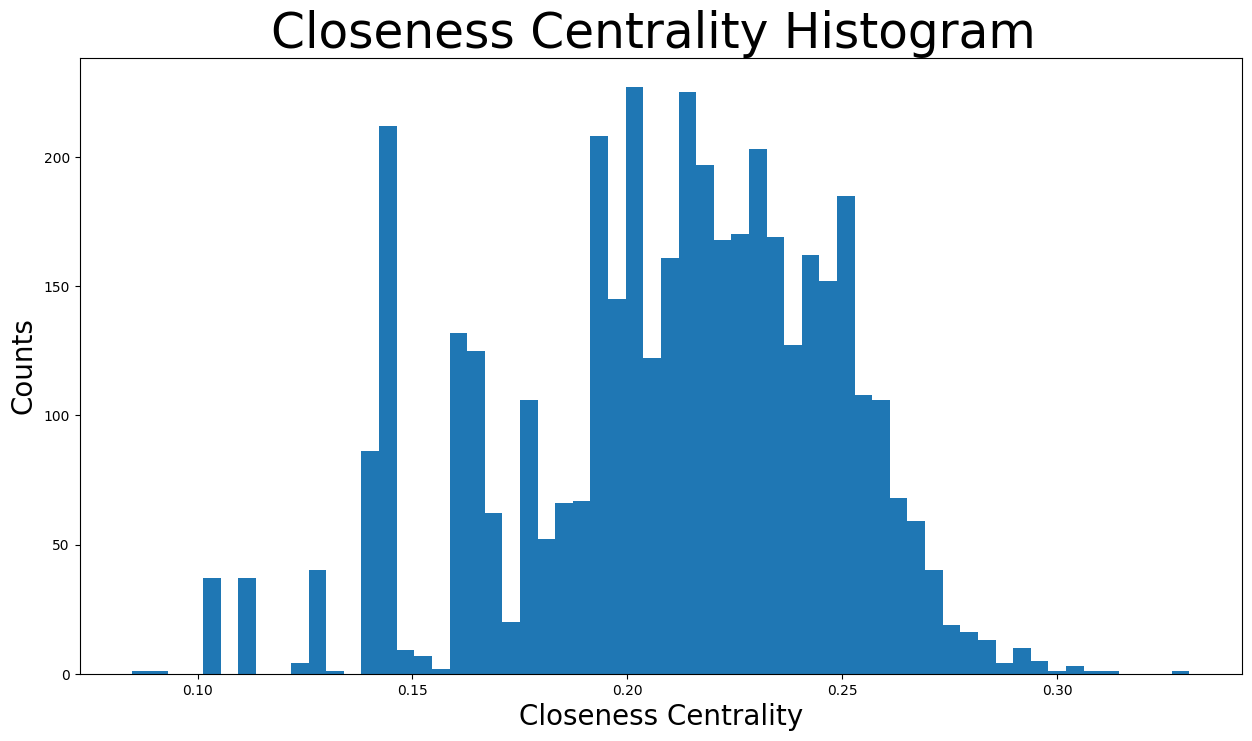

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title("Closeness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Closeness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

Según el histograma de centralidad de cercanía la mayoría de nodos tiene una centralidad de cercanía entre 0,014 y 0,25. Esto nos dice que nodos estan medianamente cerca del centro de la red y a otros nodos en general. Pero varias comunidades se encuentran más alejadas presentando centralidades muy bajas.

(-0.5816506557166576,
 0.6824601404368877,
 -0.6988945606350899,
 0.6674337390065194)

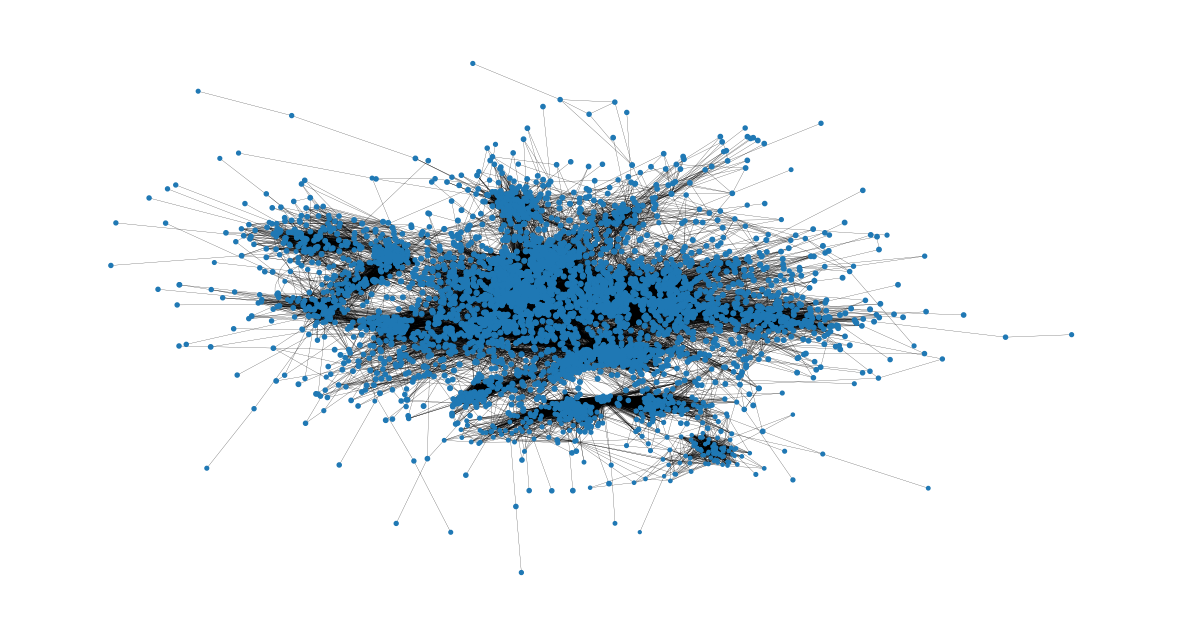

In [ ]:
node_size = [
    v * 50 for v in closeness_centrality.values()
]
plt.figure(figsize=(15, 8))
nx.draw_networkx(subgrafo, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

## Centralidad del vector propio

Esta medida puede identificar los nodos con mayor influencia en toda la red. Una centralidad de vector propio alta significa que el nodo está conectado a otros nodos que a su vez tienen centralidades de vector propio altas. En este análisis, significa la capacidad de los usuarios para influir en todo el gráfico.

Los diez nodos con mayor centralidad del vector propio son:

In [ ]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(
    subgrafo
)
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[(40981798, 0.15363590744821665),
 (43003845, 0.1507372702636457),
 (22462180, 0.14898138833635383),
 (34428380, 0.14836888505482648),
 (153226312, 0.11747403879993272),
 (270449528, 0.11544891170259039),
 (83943787, 0.11509706228160357),
 (17868918, 0.11470184783932444),
 (151338729, 0.11429285736480958),
 (279787626, 0.1140975626333083)]

Los 10 nodos con meyor centralidad de vector propio estan entre 0,114 a 0,153.
Dentro de los nodos con mayor centralidad de vector propio NO hay ninguno que sea nodo foco, ni que pertenezca a los nodos de mayor grado de intermediación, ni cercanía de centralidad. Sin embargo, los nodos 4300384, 34428380 y 22462180 pertenecen a los nodos con mayor grado de centralidad.

In [ ]:
high_eigenvector_centralities = (
    sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)
)[
    1:10
]  # 2 a 10 nodos con mayor eigen value
high_eigenvector_nodes = [
    tuple[0] for tuple in high_eigenvector_centralities
]
neighbors_40981798 = [n for n in subgrafo.neighbors(40981798)]  #lista con todos los nodos
all(
    item in neighbors_40981798 for item in high_eigenvector_nodes
)  # verificar si tiene conexiones con el neighbor_40981798

True

Text(0, 0.5, 'Counts')

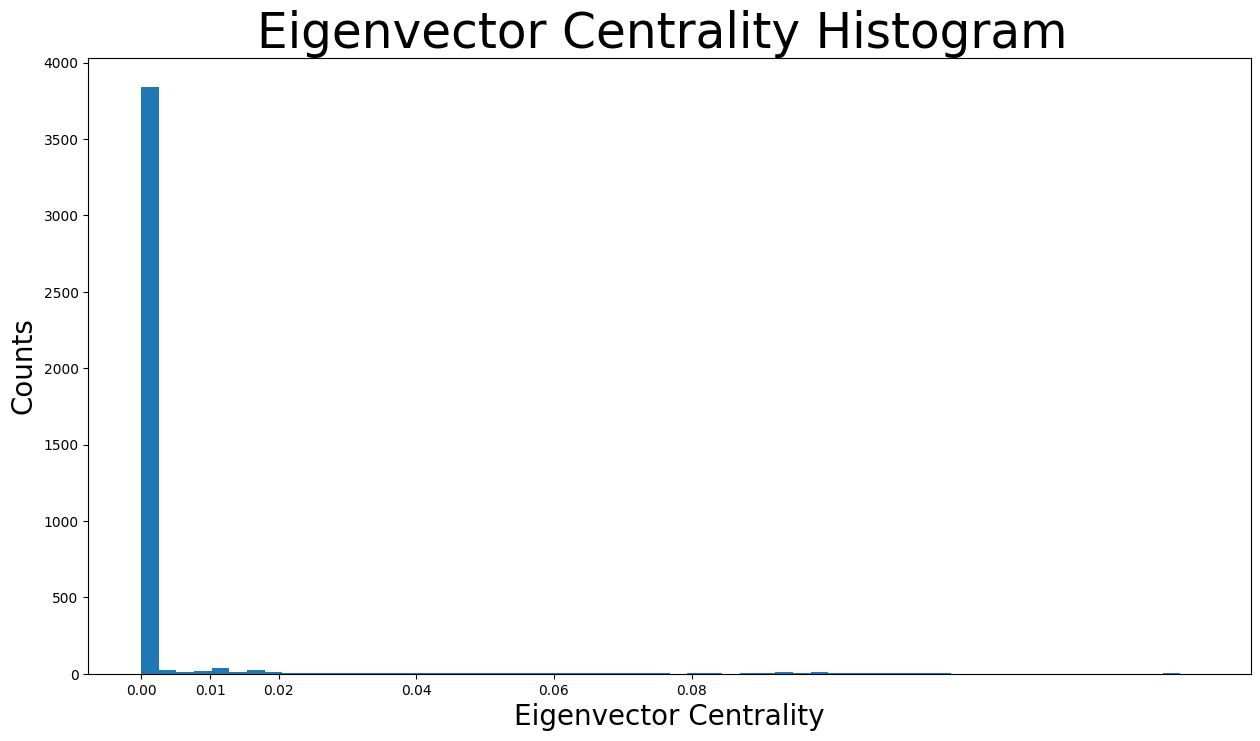

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(eigenvector_centrality.values(), bins=60)
plt.xticks(ticks=[0, 0.01, 0.02, 0.04, 0.06, 0.08])
plt.title("Eigenvector Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Eigenvector Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

Como se muestra en el histograma la mayoría de valores se encuentran por debajo de 0,005 lo que significa que son muy cercanos a 0

(-0.5816506557166576,
 0.6824601404368877,
 -0.6988945606350899,
 0.6674337390065194)

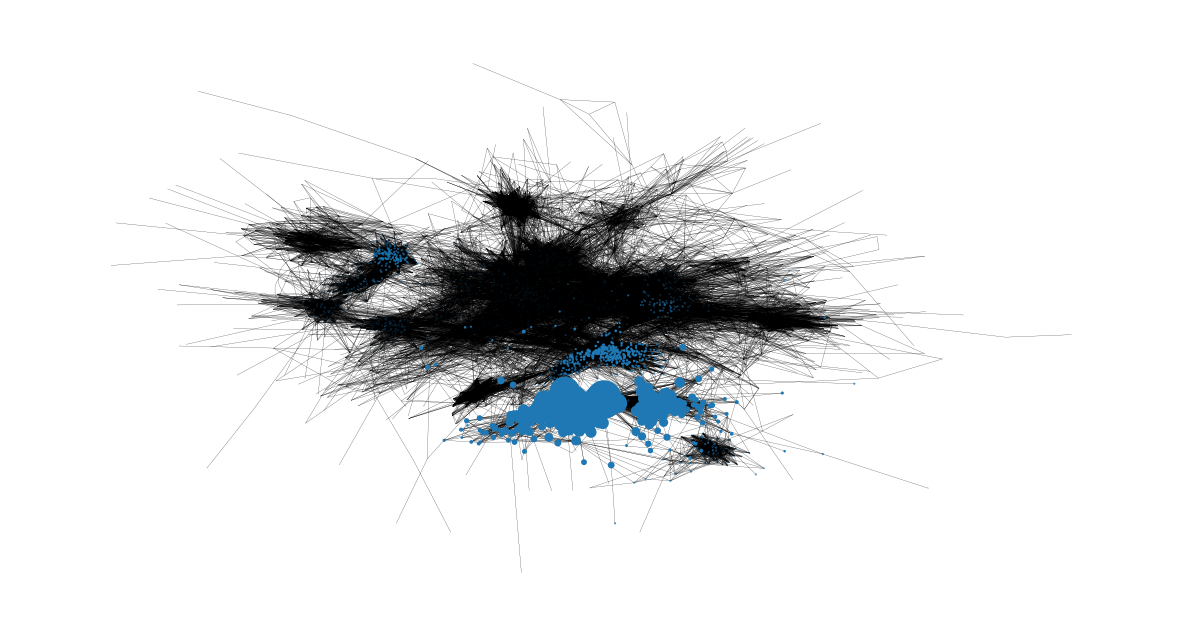

In [ ]:
node_size = [
    v * 4000 for v in eigenvector_centrality.values()
]
plt.figure(figsize=(15, 8))
nx.draw_networkx(subgrafo, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

Del gráfico anterior se puede observar que la mayor cantidad de eigenvalues sencuentran no en el cúmulo principal si no en el inferior

# **Segregación**

## Coeficiente de agrupación

El coeficiente de agrupación promedio mide cuántos de los vecinos de un nodo están conectados entre sí y se utiliza para evaluar la "localidad" o "conexión en grupos" en la red.
El coeficiente de agrupamiento promedio es la media de los coeficientes de agrupamiento de todos los nodos lo que nos da como resultado que cuanto mas cerca este este valor a 1 mas completo el gráfico será.  Un coeficiente de agrupación promedio alto indica que el grafo o subgrafo tiene una alta densidad de conexiones locales, lo que sugiere una red con fuertes agrupaciones o comunidades de nodos.

In [ ]:
nx.average_clustering(subgrafo)

0.4927802524707959

No se encuentra cercano a 1 lo que nos da entender que la gráfica no esta tan completa.
A continuación, se presenta la distribución del coeficiente de agrupación.

Text(0, 0.5, 'Counts')

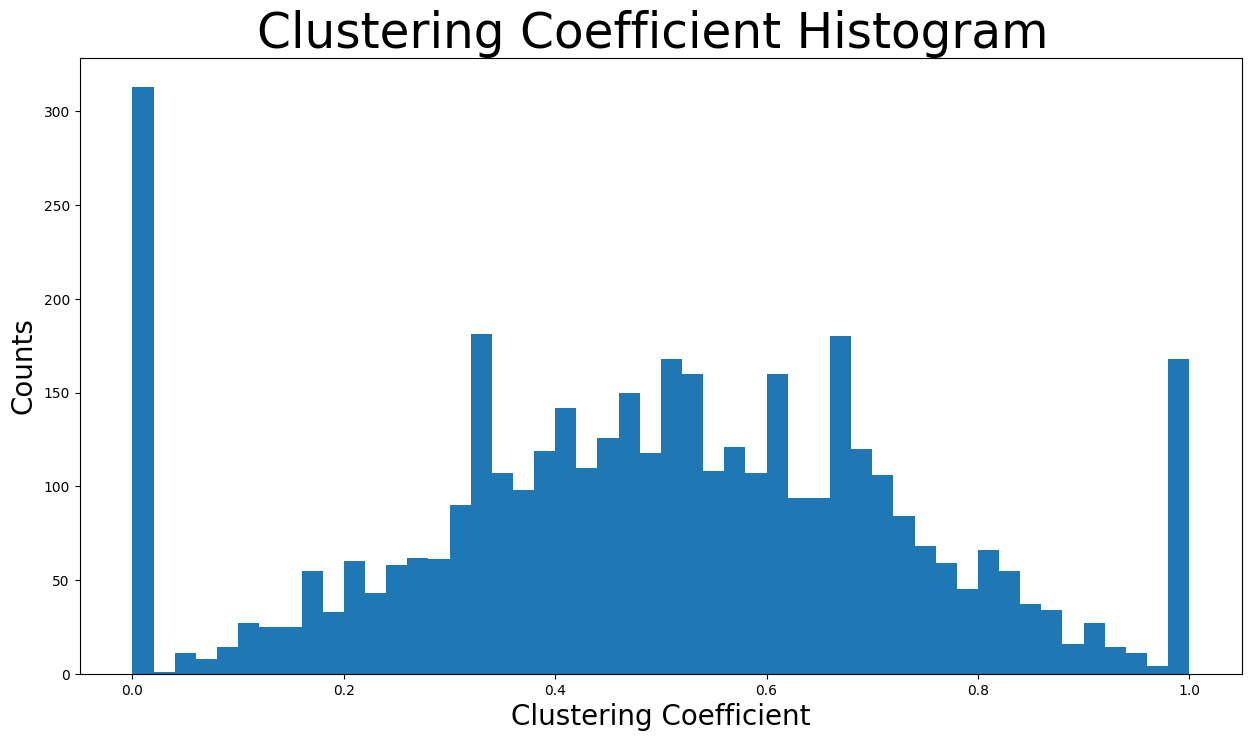

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(subgrafo).values(), bins=50)
plt.title("Clustering Coefficient Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Clustering Coefficient", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

La partición mas grande del histográma se encuentra en el 0 y son mas de 300. Pada adicionar, la mayor cantidad de nodos se encuentra entre 0,35 y 0,7.

A continuación se calculará el número único de triangulos de la red

In [ ]:
triangles_per_node = list(nx.triangles(subgrafo).values())
sum(
    triangles_per_node
) / 3

462296.0

Luego, el promedio de triangulos a los que un nodo pertenece

In [ ]:
np.mean(triangles_per_node)

334.75452570601016

Con el fin de eliminar los atípicos la mediana nos podría indicar a cuantos triangulos pertenece un nodo.

In [ ]:
np.median(triangles_per_node)

76.0

Ya que el promedio es de 334 y la mediana es 76, significa que la mayoría de los nodos pertenecen a muy pocos triangulos, mientras que, otros pertenecen a muchos triangulos

## Transitividad

La transitividad cuantifica la presencia de grupos de nodos interconectados o también llamado comunidades. A continuación se calcula la transitividad.

In [ ]:
nx.transitivity(subgrafo)

0.41115953981988157

## Puentes

Una conexión entre dos nodos A y B en el gráfico se considera un puente, si se elimina causaría que A y B se encuentren en dos componentes diferentes. A continuación se mira si hay puentes

In [ ]:
nx.has_bridges(subgrafo)

True

In [ ]:
bridges = list(nx.bridges(subgrafo))
len(bridges)

197

Hay 197 puentes. La existencia de muchos puentes se debe a los nodos de foco, ya que esos nodos de foco tienen muchos seguidores y ellos solo los siguen a ellos.

habiendo conocido los puentes se calcularán los puentes locales que son dos nodos que no tienen seguidores en común y además son puntos finales

In [ ]:
local_bridges = list(nx.local_bridges(subgrafo, with_span=False))
len(local_bridges)

962

En la siguiente visualización vemos el gráfico donde se muestran los puentes en color rojo y los puentes locales en verde

(-0.5816506557166576,
 0.6824601404368877,
 -0.6988945606350899,
 0.6674337390065194)

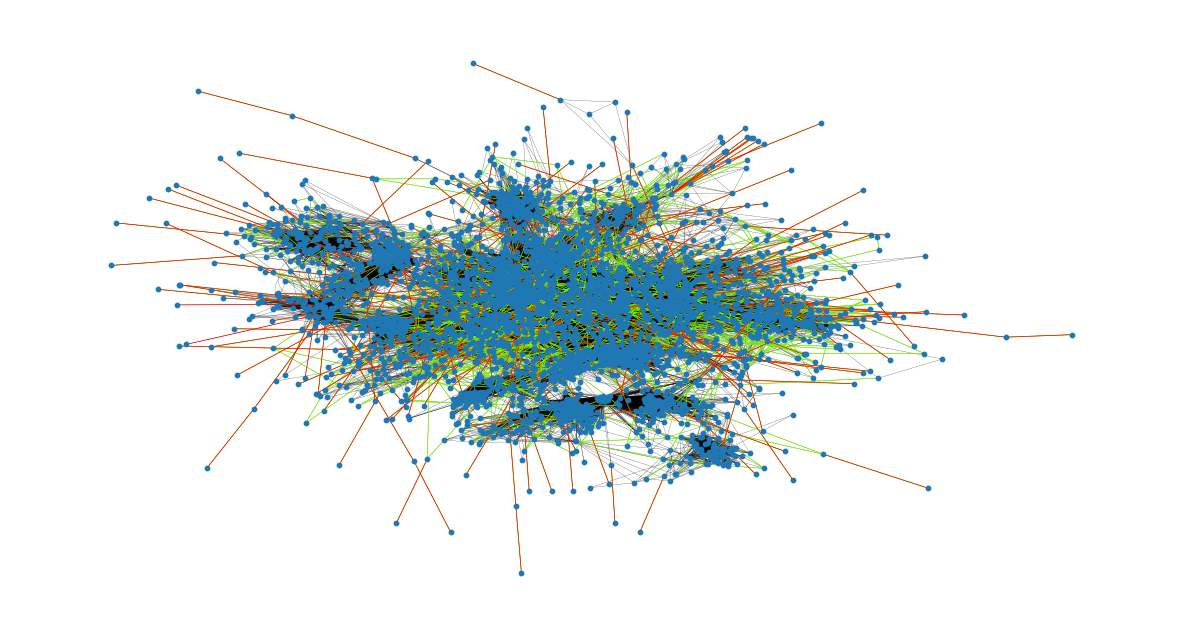

In [ ]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(subgrafo, pos=pos, node_size=10, with_labels=False, width=0.15)
nx.draw_networkx_edges(
    subgrafo, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen"
)  # green color for local bridges
nx.draw_networkx_edges(
    subgrafo, pos, edgelist=bridges, width=0.5, edge_color="r"
)  # red color for bridges
plt.axis("off")

# **Métricas de resiliencia**

## Coeficiente de asortatividad

Es la preferencia de nodos a adherirse a otros nodos.
Hay dos formas de calcular esta asortatividad

In [ ]:
nx.degree_assortativity_coefficient(subgrafo)

0.06316355042050911

In [ ]:
nx.degree_pearson_correlation_coefficient(
    subgrafo
)  # use the potentially faster scipy.stats.pearsonr function.

0.06316355042050985

Al observar que el coeficiente de pearson es positivo, y este al encontrarse entre -1 y 1 nos da entender que la correlación entre 2 nodos es similar.
En nuestro caso la asortatividad al 0,063 que es casi 0, nos da entender no tiene tanta asortatividad. En otras palabras, no podemos sacar conclusiones sobre el número de seguidores de un usuario a partir de sus otros seguidores

# **Network Communities**

Se detectarán comunidades a partir de dos métodos. La primera será mediante el método de propagación de etiquetas semisincrónicas.
Se aclara que para la generación del gráfico las diferentes comunidades serán representadas por diferentes colores, los nodos que no tengan comunidad se observaran de color blanco.

In [ ]:
colors = ["#FFFFFF" for x in range(subgrafo.number_of_nodes())]  # initialize colors list
counter = 0
for com in nx.community.label_propagation_communities(subgrafo):
    color = "#%06X" % randint(0, 0xFFF000)  # creates random RGB color
    counter += 1
    for idx, node in enumerate(list(com)):  # fill colors list with the particular color for the community nodes
        colors[idx] = color
counter

80

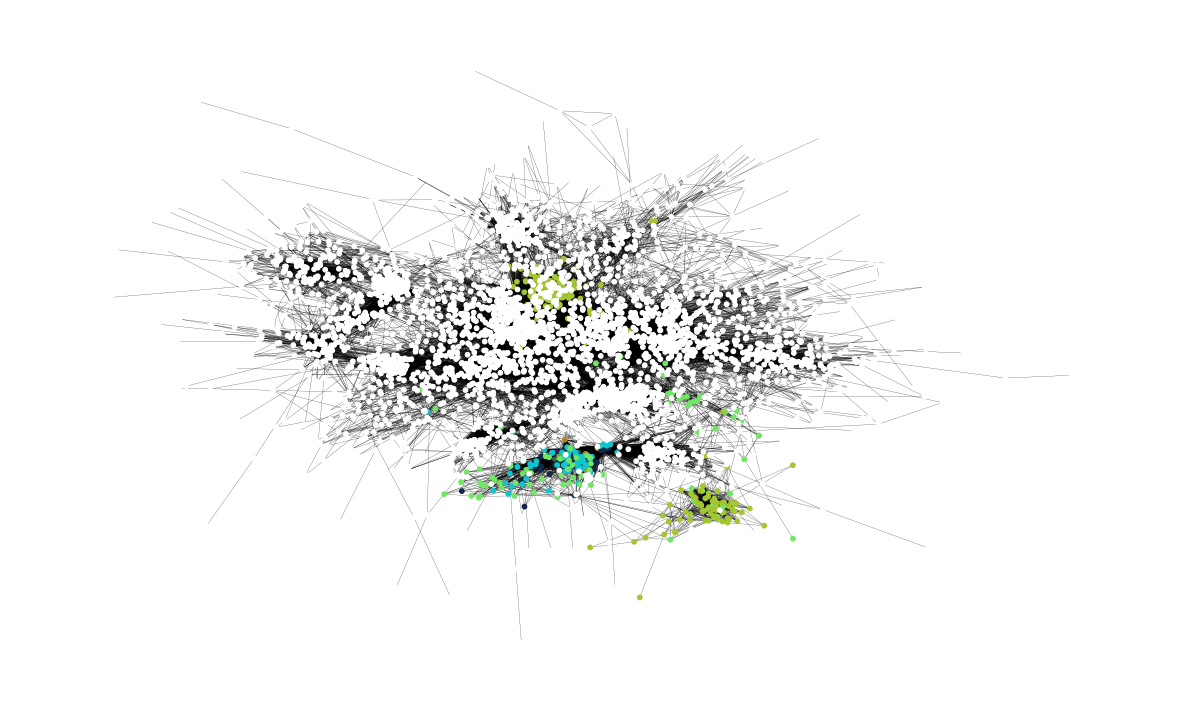

In [ ]:
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    subgrafo, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)

Como se puede observar se presentan varias comunidades (80), sin embargo, la gran mayoría de nodos no se encuentran en ninguna comunidad. Esto puede deberse por la naturaleza de Twitter en cuanto a los seguidores, puesto que se pueden seguir usuarios pero no necesariamente se siguen de vuelta.

A continuación, se realizará con el segundo método con el algoritmo de comunidades fluidas asincronas.

In [ ]:
colors = ["#FFFFFF" for x in range(subgrafo.number_of_nodes())]
for com in nx.community.asyn_fluidc(subgrafo, 8, seed=0):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    for idx, node in enumerate(list(com)):
        colors[idx] = color

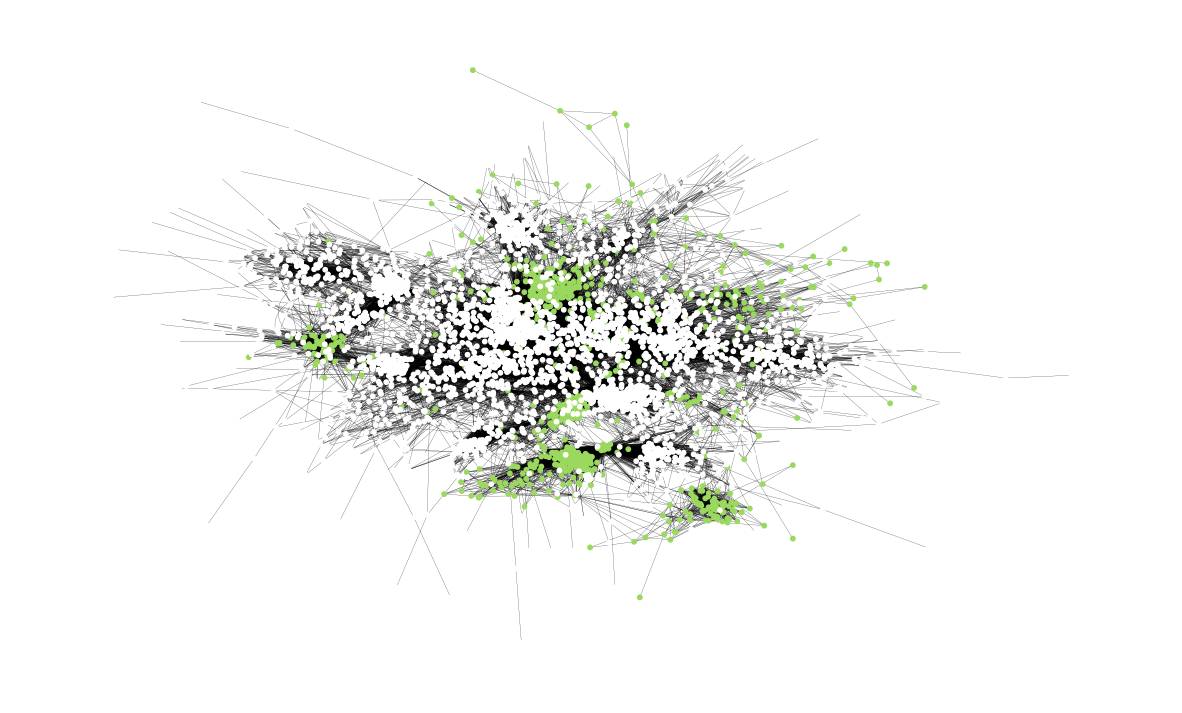

In [ ]:
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    subgrafo, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)